In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import galsim
import fpfs
from scipy.optimize import curve_fit
#import impt
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid


In [14]:
shear_value = np.linspace(0.0,0.15,40,dtype=np.float128)
shear_measure = np.zeros_like(shear_value)
scale = 0.15
nx, ny = 70, 70

for i in range(len(shear_value)):
    psfInt = galsim.Moffat(
        beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
    ).shear(e1=shear_value[i], e2=0.0)
    psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=nx, ny=ny, scale=scale).array

    # Four Galaxies to cancel spin-2 and spin-4 ansiotropies
    # spin-2 is shape noise in diagnonal elements of shear response matrix
    # spin-4 is shape noise in diagnonal and of-diagnoal elements of shear response matrix, 
    # but an order of magnitude smaller than spin-2

    gname = "g1-1"
    gal_data = fpfs.simutil.make_isolate_sim(
        gal_type="mixed",
        psf_obj=psfInt,
        gname=gname,
        seed=2,
        ny=ny,
        nx=nx*4,
        scale=scale,
        do_shift=False,
        nrot_per_gal=4,
        ngrid=nx,
        shear_value = shear_value[i]
    )[0]
    # Now we measure shear
    rcut = 32

    # Force detection
    indX = np.arange(int(nx//2), nx*4, nx)
    indY = np.arange(int(ny//2), ny, ny)
    inds = np.meshgrid(indY, indX, indexing="ij")
    coords = np.vstack([np.ravel(_) for _ in inds]).T

    fpTask  =   fpfs.image.measure_source(psfData,pix_scale = scale, sigma_arcsec=0.7)
    mms =  fpTask.measure(gal_data, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    shear_measure[i]=np.average(ells['fpfs_e1'])/resp




2023/11/09 03:34:21 ---  Creating Mixed galaxy profiles
2023/11/09 03:34:21 ---  Processing for g1-1, and shear is 0.0.
2023/11/09 03:34:21 ---  Order of the shear estimator: nnord=4
2023/11/09 03:34:21 ---  Shapelet kernel in configuration space: sigma= 0.7000 arcsec
2023/11/09 03:34:21 ---  Detection kernel in configuration space: sigma= 0.7000 arcsec
2023/11/09 03:34:21 ---  Maximum |k| is 1.616
2023/11/09 03:34:21 ---  Creating Mixed galaxy profiles
2023/11/09 03:34:21 ---  Processing for g1-1, and shear is 0.0038461538461538459337.
2023/11/09 03:34:21 ---  Order of the shear estimator: nnord=4
2023/11/09 03:34:21 ---  Shapelet kernel in configuration space: sigma= 0.7000 arcsec
2023/11/09 03:34:21 ---  Detection kernel in configuration space: sigma= 0.7000 arcsec
2023/11/09 03:34:21 ---  Maximum |k| is 1.616
2023/11/09 03:34:21 ---  Creating Mixed galaxy profiles
2023/11/09 03:34:21 ---  Processing for g1-1, and shear is 0.0076923076923076918673.
2023/11/09 03:34:21 ---  Order of 

In [15]:
c1 = shear_measure[0]
m1 = (shear_measure[1:]-c1-shear_value[1:])/shear_value[1:]

In [16]:
def model_3(x, a):
    return a * x**3
def model_2(x, a):
    return a * x**2

coefficient with just the second order term: -0.6153810073090149
coefficient with just the third order term: -4.725250757975621


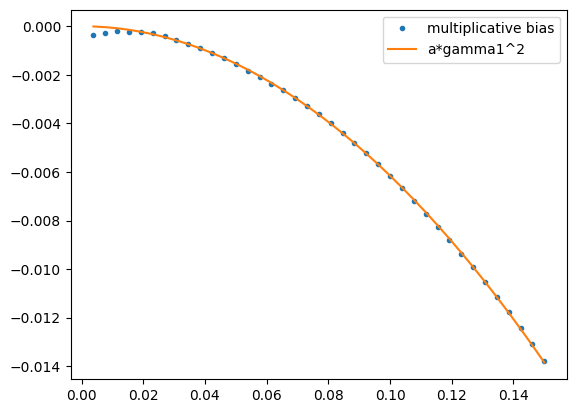

In [17]:
params3, covariance3 = curve_fit(model_3, shear_value[1:], m1)
params2, covariance2 = curve_fit(model_2, shear_value[1:], m1)
# Get the estimated value of 'a'
estimated_a3 = params3[0]
estimated_a2 = params2[0]


print(f'coefficient with just the second order term: {estimated_a2}')
print(f'coefficient with just the third order term: {estimated_a3}')

plt.plot( shear_value[1:],m1,'.',label='multiplicative bias')
plt.plot( shear_value[1:], model_2( shear_value[1:], estimated_a2), label='a*gamma1^2')
#plt.plot( shear_value[1:], model_3( shear_value[1:], estimated_a3), label='a*gamma1^3')
plt.legend()
plt.show()